In [43]:
import numpy as np
import pandas as pd
import scipy.optimize
import scipy.stats
import matplotlib.pyplot as plt
from typing import Sequence
from numpy import cumsum, log, polyfit, sqrt, std, subtract

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from scipy.stats import probplot, moment

In [44]:
import pymc3 as pm
import arviz as az
print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v3.11.4


In [ ]:
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

#Let try a usual data and see
First we create a log of returns based on the daily CLose price.

In [ ]:
returns = pd.read_csv(
    pm.get_data("SP500.csv"), parse_dates=True, index_col=0) #, usecols=["Date", "change"])
len(returns)

2906

In [ ]:
returns['Return'] = 100 * (returns['Close'].pct_change())
returns['Log_Return'] = np.log(returns['Close']).diff().mul(100) # rescale to faciliate optimization
returns = returns.dropna()

Here we create a modle to meet te conditions of parameters 
</br>
y<sub>t</sub> ∼ N (0, σ2 <sub>t</sub>)
</br>
σ<sup>2</sup>
<sub>t</sub> = α<sub>0</sub>+ α<sub>1</sub>y
<sup>2</sup>
<sub>t−1</sub> + βσ<sup>2</sup>
<sub>t−1</sub>
</br>
Parameter constraints: α<sub>0</sub> > 0, α<sub>1</sub> + β < 1 and  α<sub>0</sub> + α<sub>1</sub> + β < 1

we calculate the σ (sigma) using the sampled parameters and The final line of the model, defines ypred, the sampling distribution of the outcomes in the dataset.

In [ ]:
shape = len(returns)
with pm.Model() as garch_model:
        alpha = pm.Uniform('alpha', 0., 1., shape=1)
        beta = pm.Uniform('beta', 0., 1 - alpha, shape=1)
        alpha0 = pm.Uniform('alpha0', 0., 1 - alpha - beta, shape=1)
        Y = pm.Data("returns", returns['Log_Return'], dims="date", export_index_as_coords=True)  
        sigma = pm.HalfNormal("sigma", sigma=1)
        mu = pm.Normal('mu', mu=0., sigma=sigma, shape=shape)     
        sigma = np.sqrt(alpha0 + alpha * np.power (mu, 2) +
                        beta * np.power (sigma, 2))
        ypred=pm.Normal('ypred', mu, sigma=sigma, observed=Y)

In [ ]:
map_estimate = pm.find_MAP(model=garch_model)
map_estimate

{'alpha': array([1.]),
 'alpha0': array([0.]),
 'alpha0_interval__': array([49.09651152]),
 'alpha_interval__': array([305.03611182]),
 'beta': array([0.]),
 'beta_interval__': array([-31707026.9735666]),
 'mu': array([ 7.34876119e+07, -1.22569160e+08,  2.81885107e+08, ...,
        -2.53566322e+07, -1.15395147e+07, -1.35737197e+07]),
 'sigma': array(0.),
 'sigma_log__': array(-1020.47357931)}

In [ ]:
with garch_model:
    # draw 500 posterior samples
    trace = pm.sample(5000, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [mu, sigma, alpha0, beta, alpha]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 365 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [ ]:
with garch_model:
    display(az.summary(trace, round_to=2))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[0],-0.35,0.61,-1.62,1.04,0.04,0.03,250.51,173.39,1.01
mu[1],0.67,0.35,0.14,1.31,0.02,0.01,727.47,578.16,1.00
mu[2],-1.11,0.42,-1.85,-0.48,0.02,0.02,636.82,275.80,1.00
mu[3],0.24,0.53,-0.99,1.16,0.02,0.02,839.08,538.78,1.02
mu[4],-0.62,0.38,-1.30,-0.14,0.02,0.01,735.12,581.20,1.01
...,...,...,...,...,...,...,...,...,...
mu[2904],0.05,0.48,-0.98,1.03,0.02,0.02,779.21,514.99,1.01
alpha[0],0.94,0.02,0.89,0.97,0.00,0.00,116.17,269.83,1.03
beta[0],0.03,0.02,0.00,0.06,0.00,0.00,567.62,463.90,1.01
alpha0[0],0.01,0.01,0.00,0.03,0.00,0.00,1144.38,618.16,1.00


The model seems to ahve done well ....

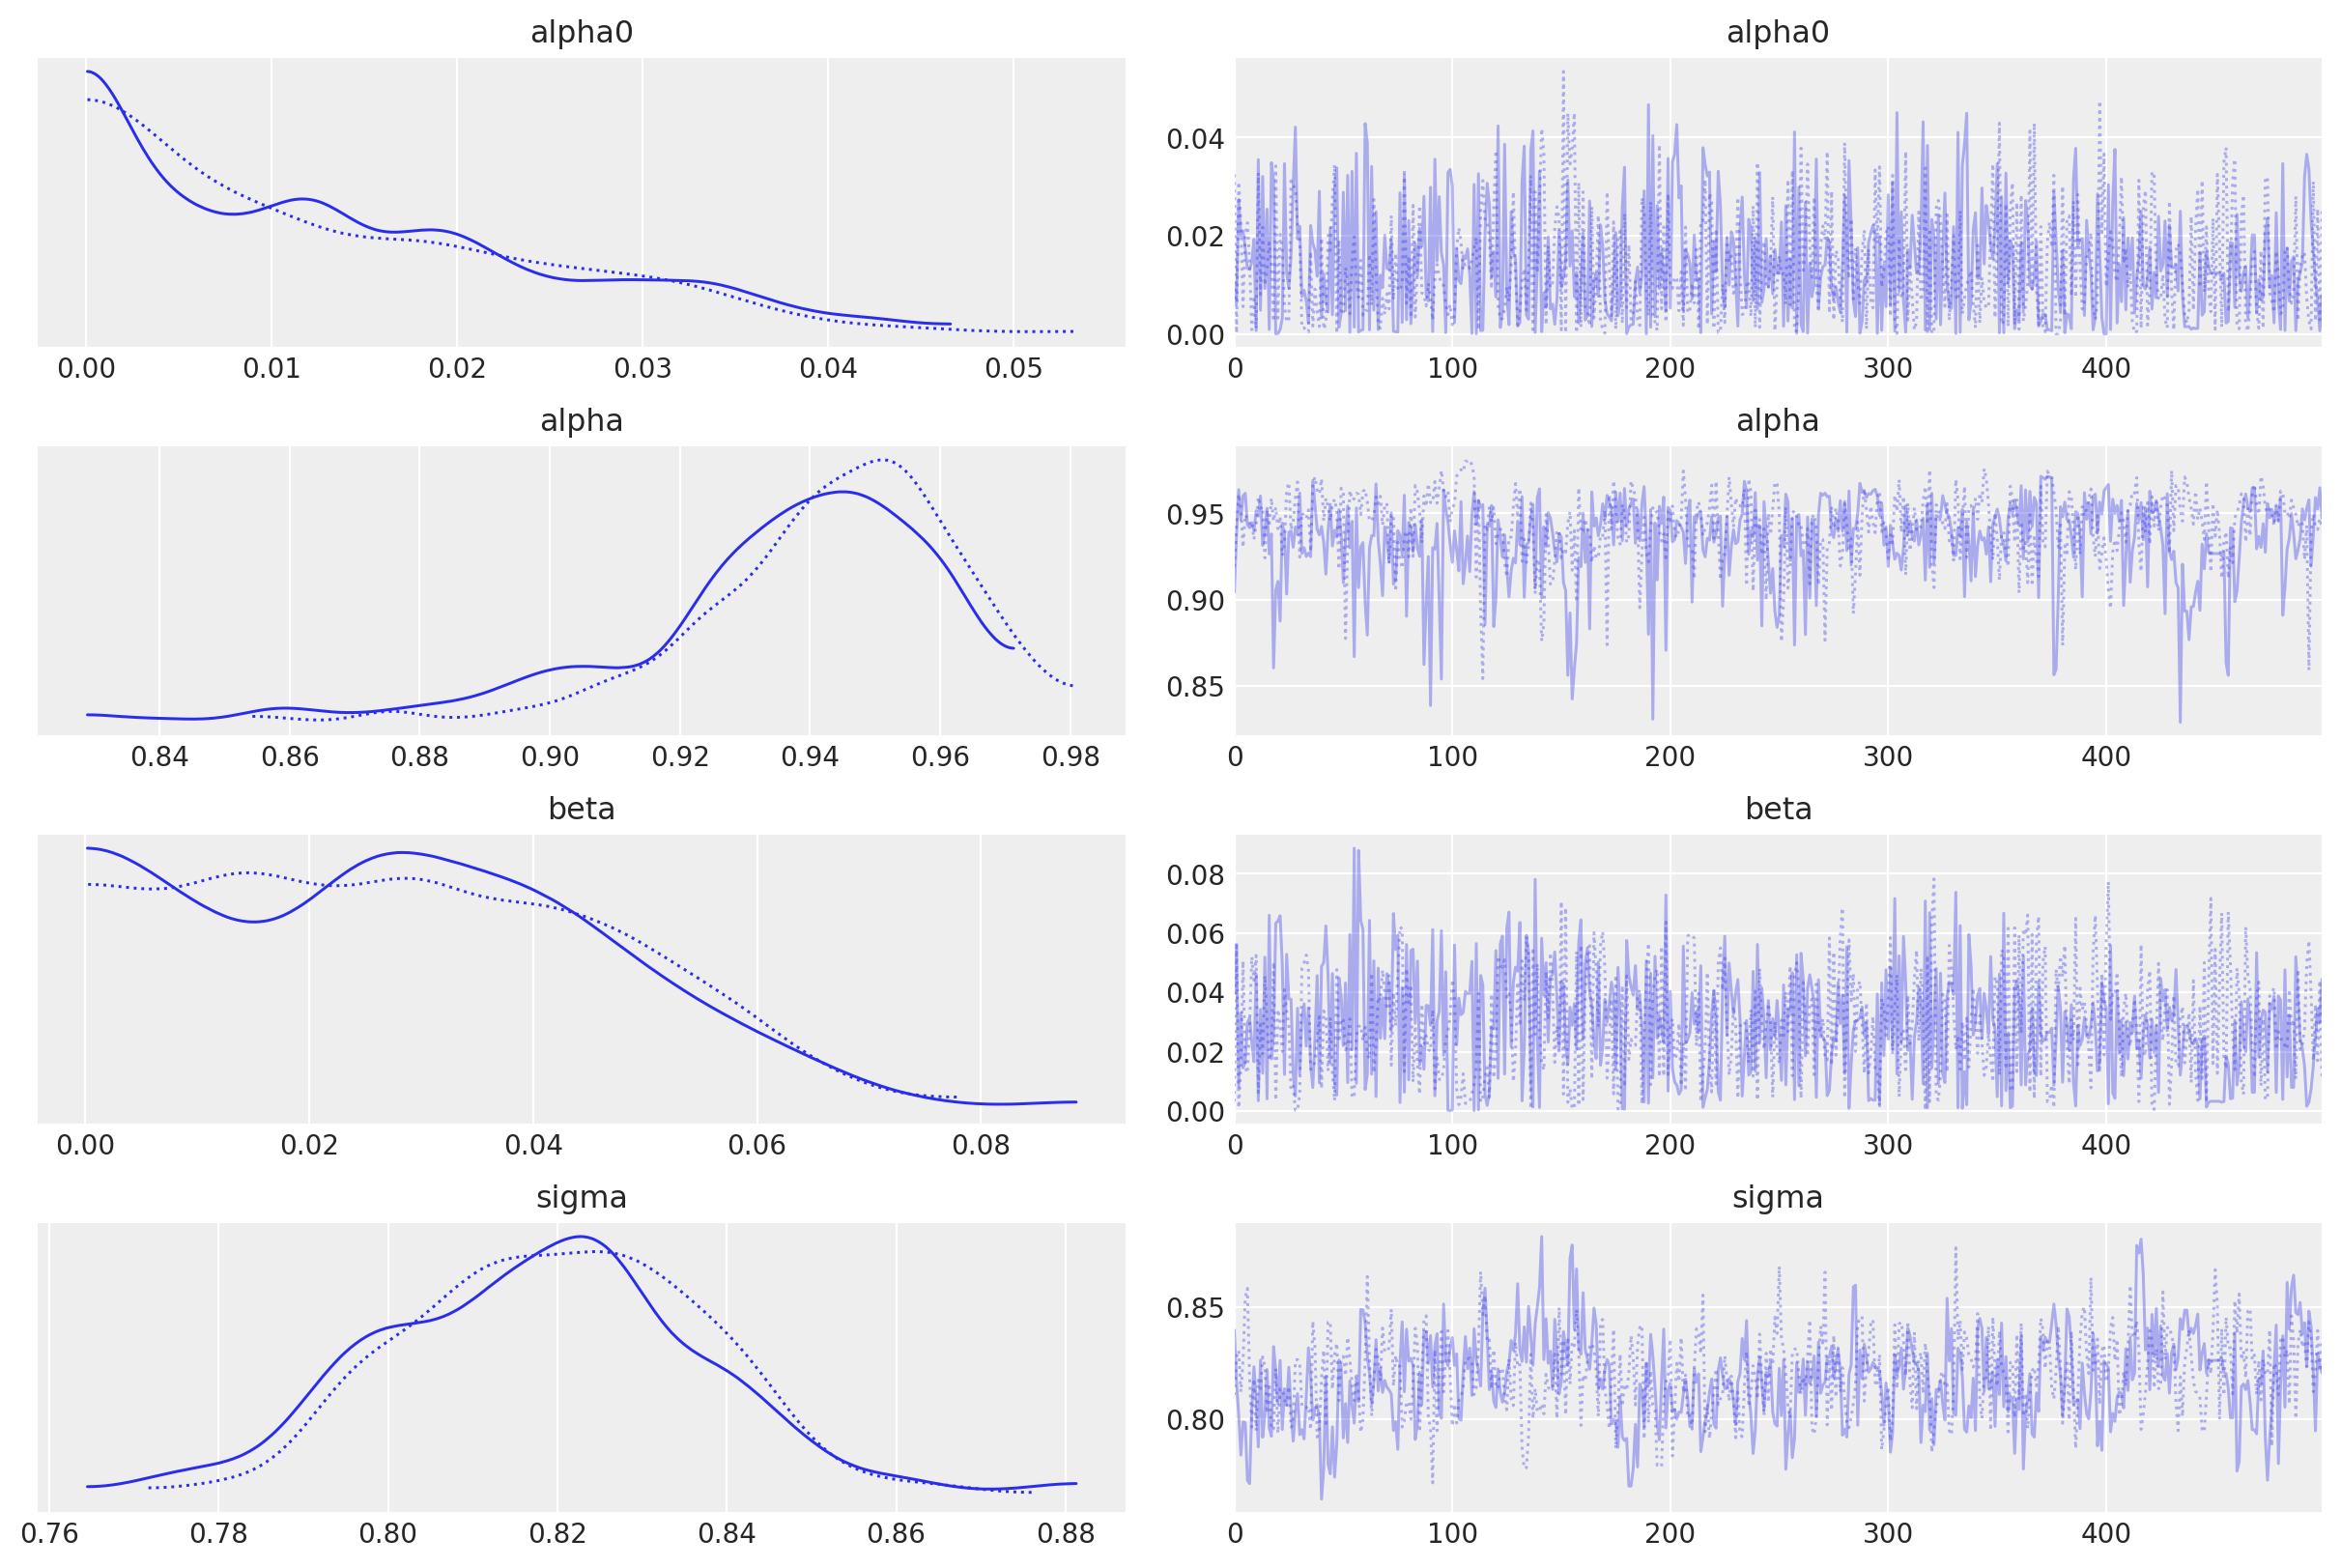

In [ ]:
with garch_model:
    az.plot_trace(trace,var_names=["alpha0","alpha","beta", "sigma"]);

Final parameters and we calculate the predicted values using the mean 'mu'

In [ ]:
beta= trace['beta'].mean()
alpha= trace['alpha'].mean()
alpha0= trace['alpha0'].mean()
sigma = trace['sigma'].mean()
mu = trace['mu'][0]
ypred = alpha0 + alpha * np.power (mu, 2) +  beta * np.power (sigma, 2)

In [ ]:
beta,alpha,alpha0,sigma,mu.mean()

(0.02661035820419033,
 0.9508109666181245,
 0.013823822517244207,
 0.8286352294851913,
 0.028478259822015465)

The parameters seems alright! 

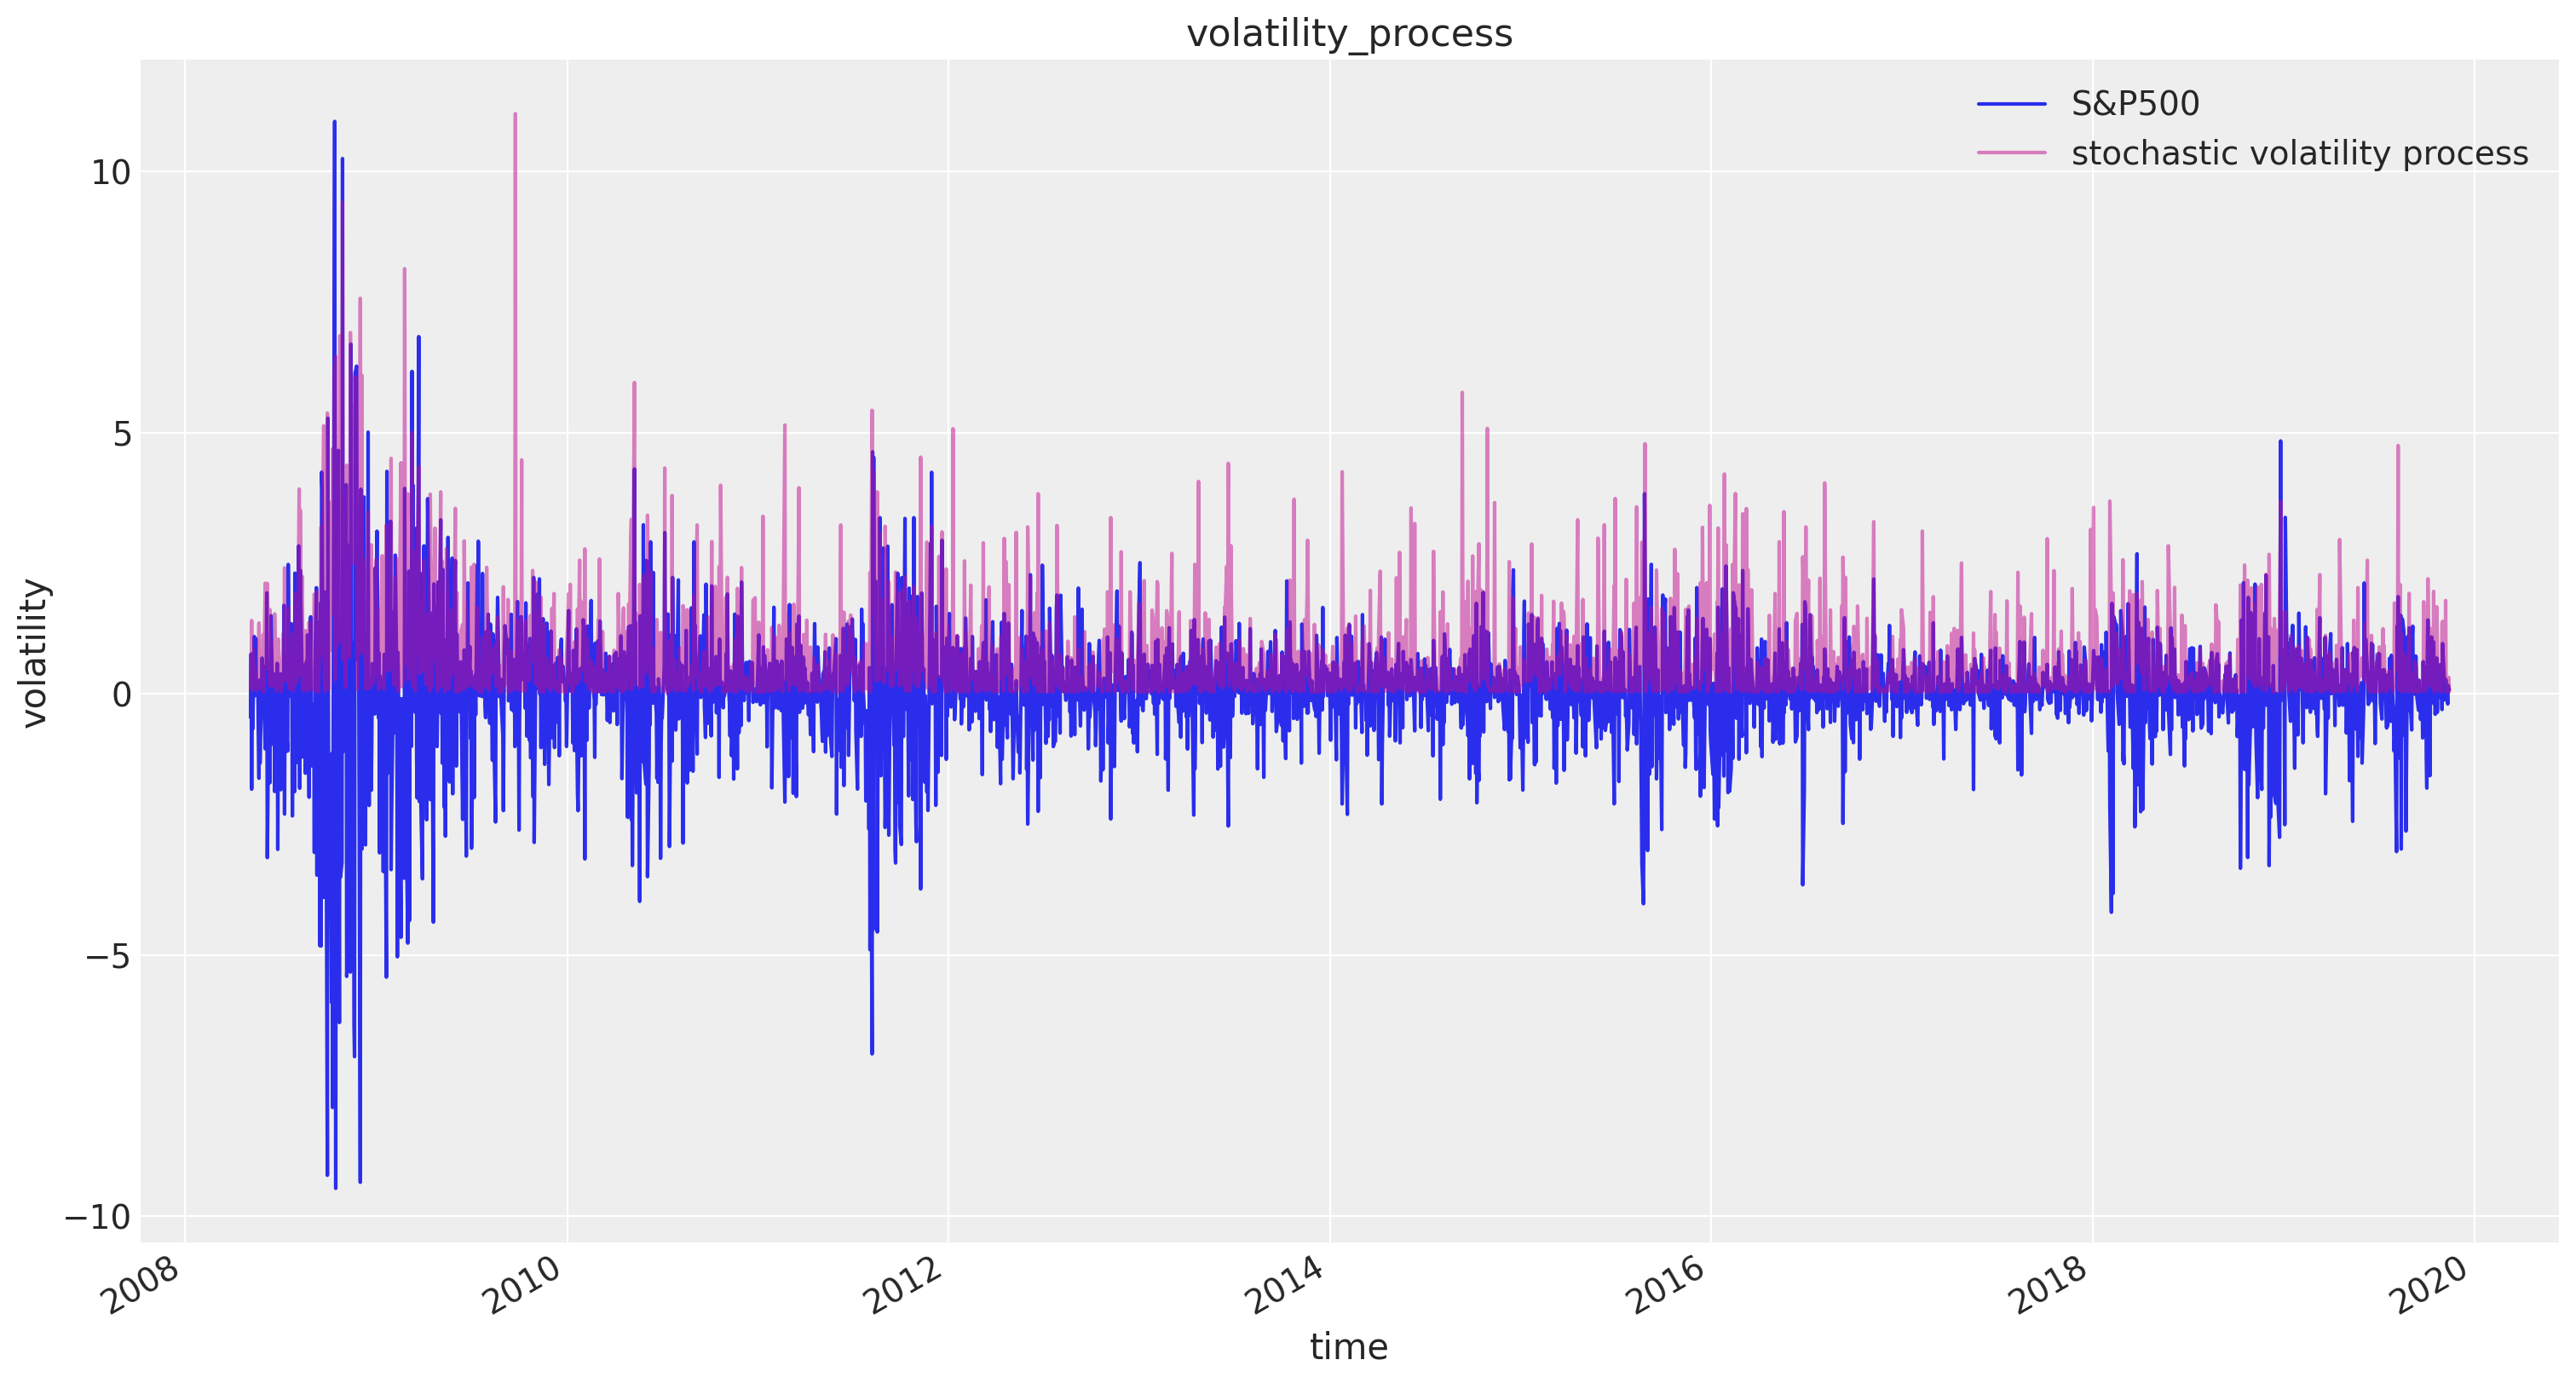

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
#returns.plot(ax=ax)
returns['Log_Return'].plot(ax=ax)
ax.plot(returns.index, ypred, "C3", alpha=0.5)
ax.set(title="volatility_process", xlabel="time", ylabel="volatility")
ax.legend(["S&P500", "stochastic volatility process"], loc="upper right");

Viola! not bad!

In [11]:
def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
    x.plot(ax=axes[0][0])
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f} \nHurst: {round(hurst(x.values),2)}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=20)
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

In [12]:
def hurst(ts):
    """Returns the Hurst Exponent of the time series vector ts"""
    # Create the range of lag values
    lags = range(2, 100)
    
    # Calculate the array of the variances of the lagged differences
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    
    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)
    
    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

#Lets try AAPL and see!

In [9]:
stock_ticker = 'AAPL'
start = pd.to_datetime(['2000-01-01']).astype(int)[0]//10**9 # convert to unix timestamp.
end = pd.to_datetime(['2021-12-31']).astype(int)[0]//10**9 # convert to unix timestamp.
url = 'https://query1.finance.yahoo.com/v7/finance/download/' + stock_ticker + '?period1=' + str(start) + '&period2=' + str(end) + '&interval=1d&events=history'
df = pd.read_csv(url)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  This is separate from the ipykernel package so we can avoid doing imports until


/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


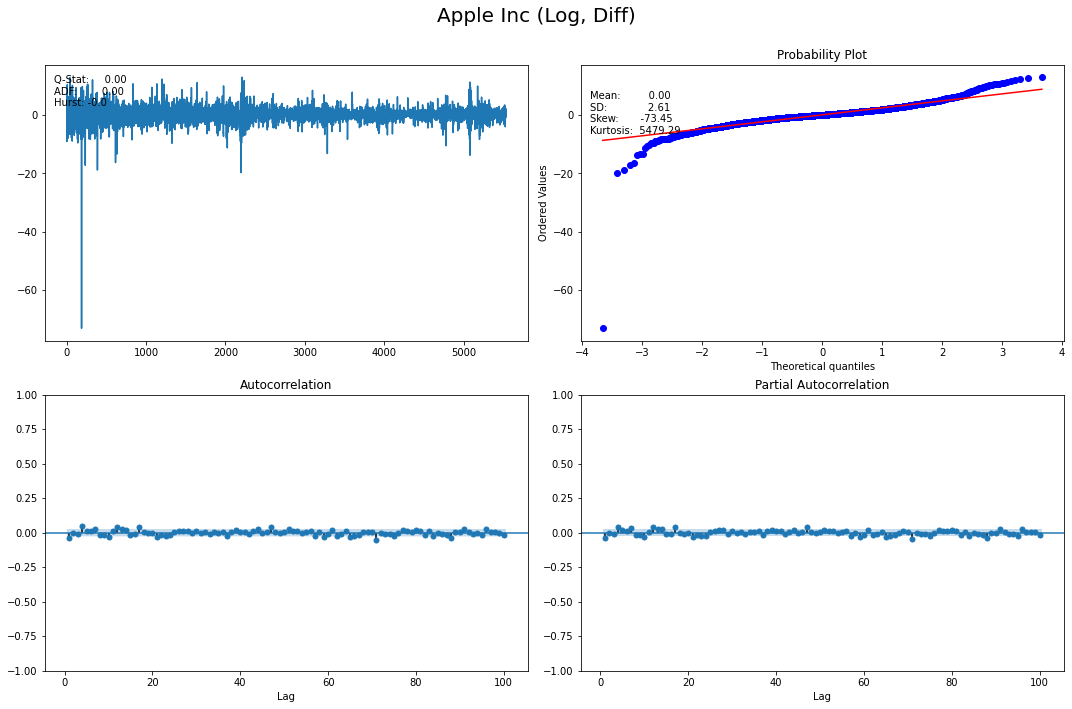

In [13]:
# Calculate daily returns as percentage price changes
df['Return'] = 100 * (df['Close'].pct_change())
df['Log_Return'] = np.log(df['Close']).diff().mul(100) # rescale to faciliate optimization
df = df.dropna()

# Plot ACF, PACF and Q-Q plot and get ADF p-value of series
plot_correlogram(df['Log_Return'], lags=100, title='Apple Inc (Log, Diff)')

Not great looking data!

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


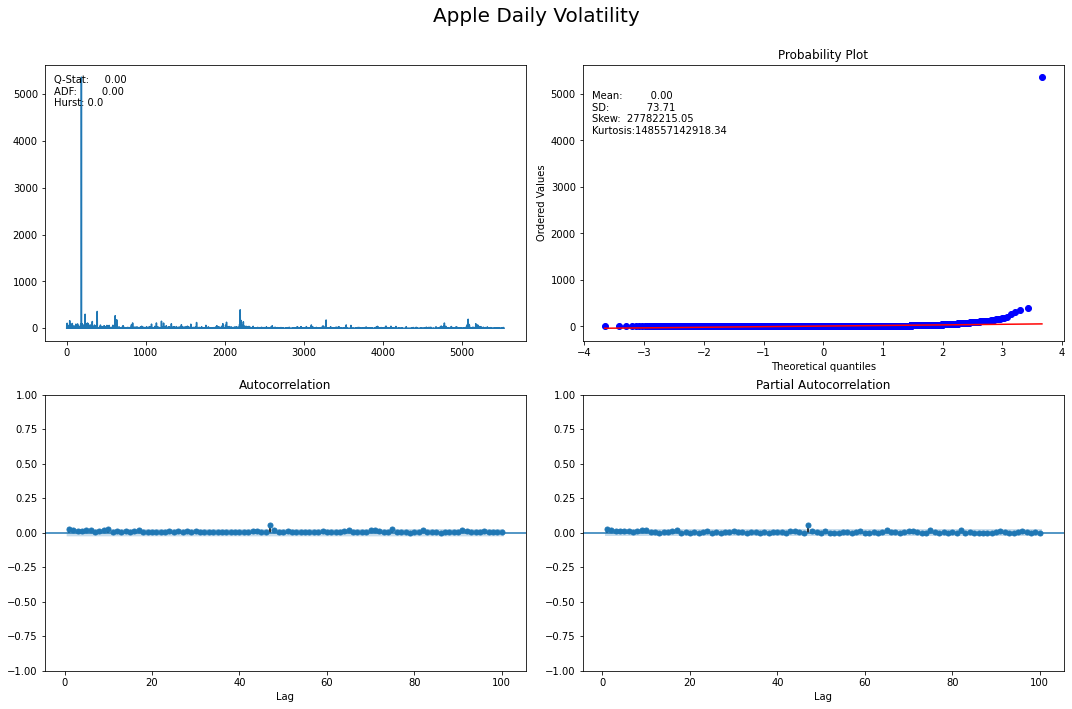

In [14]:
plot_correlogram(df['Log_Return'].sub(df['Log_Return'].mean()).pow(2), lags=100, title='Apple Daily Volatility')


In [47]:
returns = df.dropna()
shape = len(returns)
with pm.Model() as garch_model:
        alpha = pm.Uniform('alpha', 0., 1., shape=1)
        beta = pm.Uniform('beta', 0., 1 - alpha, shape=1)
        alpha0 = pm.Uniform('alpha0', 0., 1 - alpha - beta, shape=1)
        Y = pm.Data("returns", returns['Log_Return'], dims="date", export_index_as_coords=True)  
        sigma = pm.HalfNormal("sigma", sigma=1.5)
        mu = pm.Normal('mu', mu=0., sigma=sigma, shape=shape)     
        sigma = np.sqrt(alpha0 + alpha * np.power (sigma, 2)) + beta * np.power (mu, 2) 
        ypred=pm.Normal('ypred', mu, sigma=sigma, observed=Y)

In [48]:
map_estimate = pm.find_MAP(model=garch_model)
map_estimate

{'alpha': array([1.]),
 'alpha0': array([0.]),
 'alpha0_interval__': array([1.67222754]),
 'alpha_interval__': array([52.61109332]),
 'beta': array([0.]),
 'beta_interval__': array([-0.71760242]),
 'mu': array([ 0.72036763, -4.48577792,  2.29465648, ..., -0.28681588,
         0.02488944, -0.32728168]),
 'sigma': array(1.3842185),
 'sigma_log__': array(0.32513572)}

In [78]:
SEED = 123456789
CORES = 3

SAMPLE_KWARGS = {
    'cores': CORES,
    'random_seed': [SEED + i for i in range(CORES)],
    'return_inferencedata': False,
    'target_accept': 0.95,
    'tune': 5000
}
with garch_model:
    trace = pm.sample(**SAMPLE_KWARGS)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [mu, sigma, alpha0, beta, alpha]


Sampling 3 chains for 5_000 tune and 1_000 draw iterations (15_000 + 3_000 draws total) took 620 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [79]:
with garch_model:
    display(az.summary(trace, round_to=2))
    idata = az.from_pymc3(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[0],0.48,1.15,-2.14,2.36,0.03,0.02,1860.12,1720.11,1.01
mu[1],-0.61,3.13,-3.98,4.60,1.76,1.39,4.75,25.21,1.67
mu[2],2.02,0.66,0.94,3.26,0.03,0.02,659.33,1096.14,1.01
mu[3],-0.65,1.13,-2.64,1.88,0.03,0.02,2497.21,1652.44,1.00
mu[4],-2.18,0.67,-3.47,-1.10,0.07,0.05,125.93,780.55,1.02
...,...,...,...,...,...,...,...,...,...
mu[5532],-0.21,0.97,-2.05,1.73,0.01,0.02,4731.60,1462.96,1.00
alpha[0],0.44,0.11,0.21,0.57,0.04,0.03,11.61,11.64,1.19
beta[0],0.43,0.06,0.32,0.52,0.03,0.02,4.83,11.16,1.66
alpha0[0],0.08,0.11,0.00,0.29,0.04,0.03,10.74,18.08,1.19


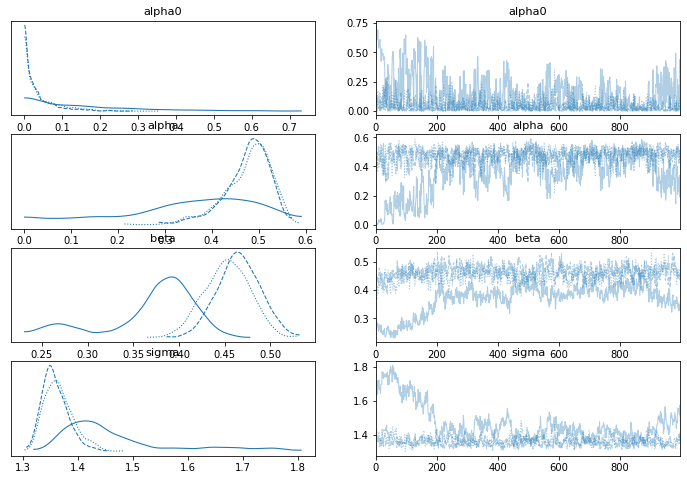

In [80]:
with garch_model:
    az.plot_trace(trace,var_names=["alpha0","alpha","beta", "sigma"]);

In [81]:
trace.varnames

['alpha_interval__',
 'beta_interval__',
 'alpha0_interval__',
 'sigma_log__',
 'mu',
 'alpha',
 'beta',
 'alpha0',
 'sigma']

In [82]:
beta= trace["beta"].mean()
alpha= trace['alpha'].mean()
alpha0= trace['alpha0'].mean()
sigma = trace['sigma'].mean()
mu = trace['mu'][0]
ypred = np.sqrt(alpha0 + alpha * np.power (sigma, 2)) + beta * np.power (mu, 2) 

Not great but lets see

In [76]:
beta,alpha,alpha0,sigma,mu[-1]

(0.452226438764501,
 0.46997252085577396,
 0.04702740307428658,
 1.3687320227924347,
 0.32404365184434586)

Seems OK! but not as good as S&P index!

Lets super overlay and see!

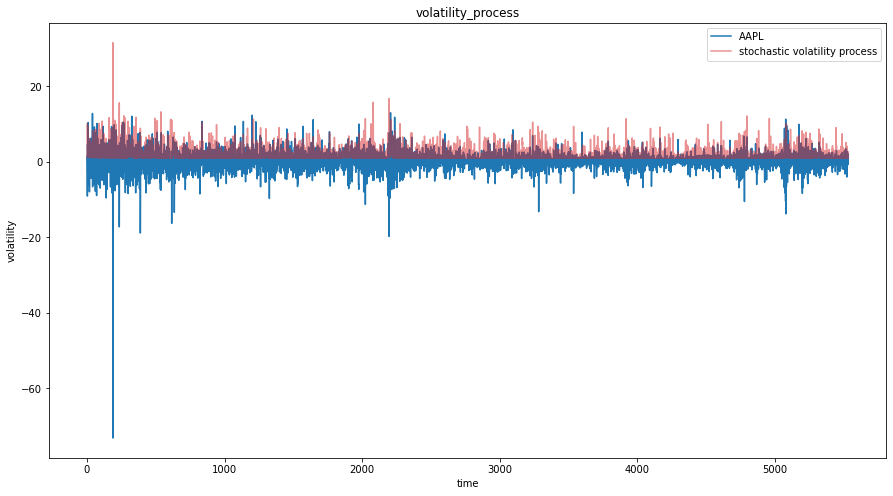

In [94]:
fig, ax = plt.subplots(figsize=(15, 8))
returns['Log_Return'].plot(ax=ax)
ax.plot(returns.index, ypred, "C3", alpha=0.5)
ax.set(title="volatility_process", xlabel="time", ylabel="volatility")
ax.legend(["AAPL", "stochastic volatility process"], loc="upper right");

Great! another accoplishment! feels good! Enjoy!

# Lets compare with arch library

In [3]:
!pip install arch

In [4]:
from arch import arch_model

In [17]:
# Specify EGARCH model assumptions
returns = df.dropna()
garch_gm = arch_model(returns['Log_Return'], p = 3, q = 1, o = 1, vol = 'GARCH', dist = 't')

# Fit the model
garch_result = garch_gm.fit(disp = 'off')

# Print model fitting summary
print(garch_result.summary())

                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                   Log_Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -11756.9
Distribution:      Standardized Student's t   AIC:                           23529.9
Method:                  Maximum Likelihood   BIC:                           23582.8
                                              No. Observations:                 5533
Date:                      Thu, Feb 03 2022   Df Residuals:                     5532
Time:                              00:56:45   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0

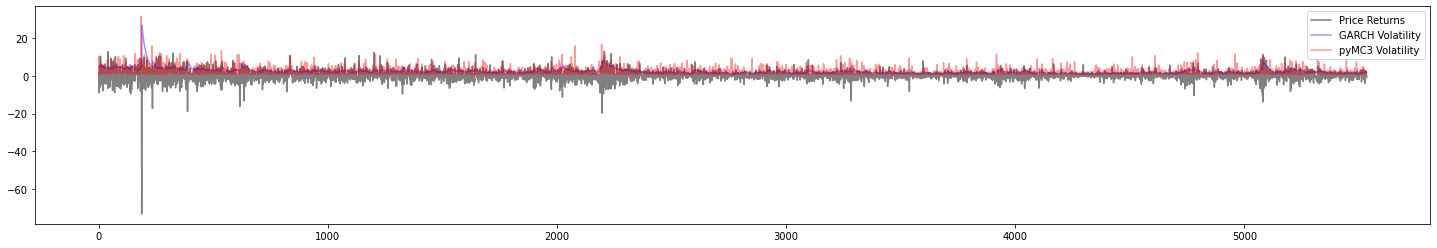

In [85]:
garch_vol = garch_result.conditional_volatility
plt.figure(figsize=(25,4))
# Plot the actual Bitcoin returns
plt.plot(returns['Log_Return'], color = 'grey', label = 'Price Returns')

# Plot GARCH estimated volatility
plt.plot(garch_vol, color = 'blue', label = 'GARCH Volatility', alpha = 0.4,)
# Plot pyMC3 estimated volatility
plt.plot(ypred, color = 'red', label = 'pyMC3 Volatility',alpha = 0.4,)
plt.legend(loc = 'upper right')
plt.show()

In [46]:
garch_result.params

mu          0.143361
omega       0.061501
alpha[1]    0.054239
alpha[2]    0.000000
alpha[3]    0.000000
gamma[1]    0.074120
beta[1]     0.904384
nu          4.891411
Name: params, dtype: float64

In [93]:
idata


Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

Can we say pyMC3 does it better but over does it!!